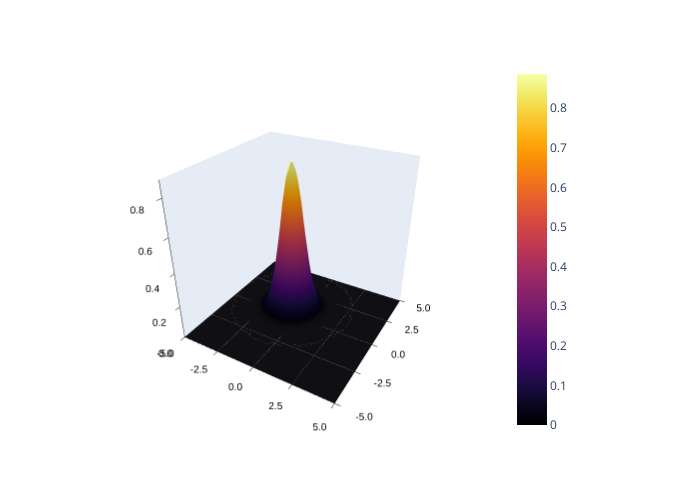

In [302]:
using Plots; plotlyjs()
using LinearAlgebra
using CUDA

maxPos = 5
minPos = -5
stepPos = 0.25

freePropagator(qf, q0, tf, t0 = 0, m = 1) = sqrt(m / (2 * pi * im * (tf - t0))) * exp(im * m / (2 * (tf - t0)) * (qf - q0)^2)  
freePropagatorC(qf, qfp, q0, q0p, tf, t0) = freePropagator(qf, q0, tf, t0) * freePropagator(qfp, q0p, tf, t0)
initStateFunction(q0, q0p, σ1, s1, p1, σ2, s2, p2) = (1//2 * pi * σ1)^(1//4) * exp(-(q0 - s1)^2 / (4 * σ1^2) + im * p1 * q0) * (1//2 * pi * σ2)^(1//4) * exp(-(q0p - s2)^2 / (4 * σ2^2) + im * p2 * q0p)
posToIndex(pos) = Int32((pos - minPos) / stepPos + 1)

pos1Vect = collect(minPos:stepPos:maxPos)
pos2Vect = collect(minPos:stepPos:maxPos)
posVectSize = size(pos1Vect, 1)
posMat = [(i, j) for i in pos1Vect, j in pos2Vect]

initState(q) = initStateFunction(q[1], q[2], 0.5, +1, 0, 0.5, -1, 0)# + initStateFunction(q[1], q[2], 0.5, -3, 0, 0.5, +3, 0)
initMat = initState.(posMat)
initMat = round.(initMat, digits = 6)
initMatCu = CuArray(initMat)

α = 2
m = 1

# springPropagator1(qf, qfp, q0, q0p, tf, t0) = freePropagatorC(qf, qfp, q0, q0p, tf, t0)# .* (1 - im * α * tf / 6 * (-2 * (m * (q0 + qf)^2 + m * (q0p + qfp)^2 + im * tf) + 2*q0*q0p + q0*qfp + q0p*qf + 2*qf*qfp))

surface(pos1Vect, pos2Vect, abs.(initMat))

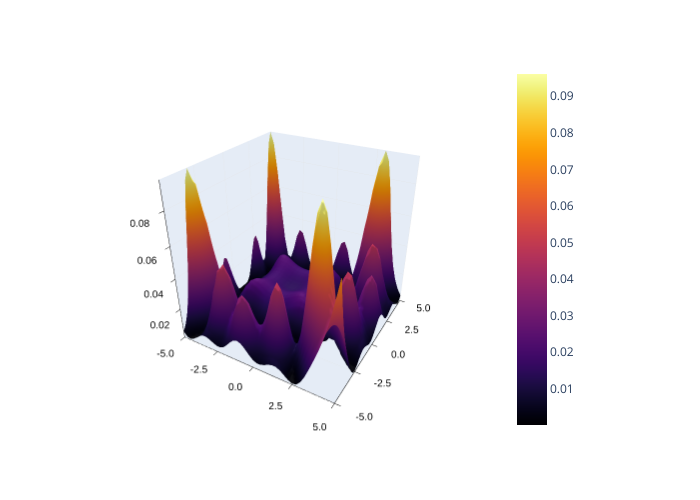

In [306]:
xMesh = pos1Vect * ones(posVectSize)'
yMesh = xMesh'
xMeshCu = CuArray(xMesh)
yMeshCu = CuArray(yMesh)

CUDA.allowscalar(false)

finalMat = Matrix{ComplexF32}(undef, posVectSize, posVectSize)

global α, m, finalTime
α = 0
m = 1
finalTime = 0.01
springPropagator1(qf, qfp, q0, q0p, tf, t0) = @. sqrt(m / (2 * pi * im * (tf - t0))) * exp(im * m / (2 * (tf - t0)) * (qf - q0)^2) * sqrt(m / (2 * pi * im * (tf - t0))) * exp(im * m / (2 * (tf - t0)) * (qfp - q0p)^2) * (1 - im * α * tf / 6 * (-2 * (m * (q0 + qf)^2 + m * (q0p + qfp)^2 + im * tf) + 2*q0*q0p + q0*qfp + q0p*qf + 2*qf*qfp))
freeProp(qf, qfp, q0, q0p, tf, t0) = @. sqrt(m / (2 * pi * im * (tf - t0))) * exp(im * m / (2 * (tf - t0)) * (qf - q0)^2) * sqrt(m / (2 * pi * im * (tf - t0))) * exp(im * m / (2 * (tf - t0)) * (qfp - q0p)^2)

for i in pos1Vect, j in pos2Vect
	propMat = freeProp(i, j, xMeshCu, yMeshCu, finalTime, 0)
	propMat .*= initMatCu
	finalMat[posToIndex(i), posToIndex(j)] = reduce(+, propMat)
end
surface(pos1Vect, pos2Vect, normalize(abs2.(finalMat)))